# 1.9g: Exponent-Matched Neighborhood

From 1.9f we know the 13 black holes form a complete graph (every BH adjacent to every other).

**Question:** Are there singleton tokens living in the same bfloat16 "hypercube" as the black holes?

**Hypothesis:** During early training, thermal diffusion caused some tokens to random-walk outward from the primordial initialization point, then freeze in nearby lattice cells. These would form a diffuse cloud of singletons surrounding the dense BH core.

**Method:**
1. Extract the shared exponent of the 13 BHs in each dimension (all 2,560 dimensions)
2. Find all tokens in the vocabulary that match these exponents in EVERY dimension
3. This defines the "exponent-matched neighborhood" — tokens at the same scale as the BHs
4. Categorize: black holes vs singletons vs small clusters
5. Analyze uint16 distances within the neighborhood
6. Test the diffusion cloud hypothesis

**Expected result:** If diffusion occurred, we should find ~100 singletons (order of magnitude more than 13 BHs) in the exponent-matched neighborhood.

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Active dimensions from 1.9c (for reference, but we'll check all 2560)
ACTIVE_DIMS = [216, 282, 322, 450, 993, 1008, 1149, 1155, 1272, 1382, 
               1403, 1435, 1487, 1564, 1763, 2012, 2040, 2079, 2143, 2479]

## Imports

In [2]:
import torch
import ml_dtypes
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from collections import defaultdict, Counter
from tqdm import tqdm

## Helper Functions

In [3]:
def extract_exponent_fast(uint16_val):
    """Extract exponent from uint16 representation of bfloat16."""
    return (uint16_val >> 7) & 0xFF  # Bits 1-8 are exponent

def decode_bfloat16_bits(value_bf16):
    """Decode a bfloat16 value into its bit components."""
    bits_uint16 = np.frombuffer(value_bf16.tobytes(), dtype=np.uint16)[0]
    bits_binary = format(bits_uint16, '016b')
    
    sign_bit = bits_binary[0]
    exponent_bits = bits_binary[1:9]
    mantissa_bits = bits_binary[9:16]
    
    sign = int(sign_bit)
    exponent = int(exponent_bits, 2)
    mantissa = int(mantissa_bits, 2)
    
    return {
        'bits_uint16': bits_uint16,
        'bits_binary': bits_binary,
        'sign': sign,
        'exponent': exponent,
        'mantissa': mantissa,
        'sign_bit': sign_bit,
        'exponent_bits': exponent_bits,
        'mantissa_bits': mantissa_bits
    }

## Load Data

In [4]:
# Load W in bfloat16
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]

print(f"Loaded W: {W_bf16.shape}")
print(f"Dtype: {W_bf16.dtype}")

Loaded W: torch.Size([151936, 2560])
Dtype: torch.bfloat16


In [5]:
# Load corrected core data from 1.9b
core_path = Path(f"../tensors/{MODEL_NAME}/1.9b_core_bfloat16.safetensors")
core_data = load_file(core_path)

core_token_ids = core_data["core_token_ids"].to(torch.int64)
bh_labels = core_data["bh_labels"].to(torch.int64)
n_black_holes = core_data["n_black_holes"].item()

print(f"\nLoaded core data: {n_black_holes} black holes")
print(f"Core size: {len(core_token_ids):,} tokens")


Loaded core data: 13 black holes
Core size: 2,179 tokens


## Extract Black Hole Representative Vectors

In [6]:
print("\nExtracting black hole representative vectors...\n")

# For each black hole, get the first token
bh_token_ids = []
bh_populations = []

for bh_id in range(n_black_holes):
    mask = bh_labels == bh_id
    tokens_in_bh = core_token_ids[mask]
    bh_token_ids.append(tokens_in_bh[0].item())
    bh_populations.append(len(tokens_in_bh))
    print(f"BH{bh_id:2d}: {len(tokens_in_bh):4,} tokens")

# Extract vectors in bfloat16
bh_vectors_bf16 = [W_bf16[token_id] for token_id in bh_token_ids]

# Convert to uint16 (raw bits)
bh_vectors_uint16 = [vec.cpu().view(torch.uint16).numpy() for vec in bh_vectors_bf16]

print(f"\n✓ Extracted {len(bh_vectors_bf16)} black hole vectors")
print(f"  Converted to uint16 (raw bits)")


Extracting black hole representative vectors...

BH 0:  814 tokens
BH 1:  704 tokens
BH 2:  306 tokens
BH 3:  228 tokens
BH 4:   11 tokens
BH 5:   10 tokens
BH 6:    6 tokens
BH 7:    5 tokens
BH 8:    4 tokens
BH 9:    4 tokens
BH10:    3 tokens
BH11:    3 tokens
BH12:    2 tokens

✓ Extracted 13 black hole vectors
  Converted to uint16 (raw bits)


## Extract Shared Exponents (All 2,560 Dimensions)

In [7]:
print("\nExtracting shared exponents across all 2,560 dimensions...\n")

n_dims = W_bf16.shape[1]  # 2560

# For each dimension, get the shared exponent of the 13 BHs
bh_exponents = np.zeros(n_dims, dtype=np.uint8)

for dim in range(n_dims):
    # All 13 BHs should share the same exponent in this dimension
    # (We verified this for active dims in 1.9e; inactive dims have identical values)
    bh_vec_uint16 = bh_vectors_uint16[0][dim]
    bh_exponents[dim] = extract_exponent_fast(bh_vec_uint16)

print(f"✓ Extracted shared exponents for all {n_dims} dimensions")

# Sanity check: verify all 13 BHs actually share these exponents
print("\nVerifying exponent sharing across all 13 black holes...")
mismatch_count = 0
for dim in range(n_dims):
    expected_exp = bh_exponents[dim]
    for bh_vec in bh_vectors_uint16:
        actual_exp = extract_exponent_fast(bh_vec[dim])
        if actual_exp != expected_exp:
            mismatch_count += 1
            if mismatch_count <= 5:  # Show first 5 mismatches
                print(f"  WARNING: Exponent mismatch in dimension {dim}")

if mismatch_count == 0:
    print("✓ All 13 black holes share the same exponent in every dimension.")
else:
    print(f"⚠ Found {mismatch_count} exponent mismatches across all dimensions.")
    print(f"  (This might indicate numerical issues or our assumption is wrong.)")


Extracting shared exponents across all 2,560 dimensions...

✓ Extracted shared exponents for all 2560 dimensions

Verifying exponent sharing across all 13 black holes...
✓ All 13 black holes share the same exponent in every dimension.


## Find Exponent-Matched Neighborhood

In [8]:
print("\nSearching for exponent-matched neighborhood...")
print("(This checks all 151,936 tokens × 2,560 dimensions)\n")

# Convert entire W to uint16 for fast exponent extraction
W_uint16 = W_bf16.cpu().view(torch.uint16).numpy()  # Shape: (151936, 2560)

# Extract exponents for all tokens in all dimensions
print("Extracting exponents for entire vocabulary...")
W_exponents = (W_uint16 >> 7) & 0xFF  # Shape: (151936, 2560), dtype=uint16

print("✓ Extracted exponents\n")

# Find tokens that match BH exponents in ALL dimensions
print("Finding tokens with matching exponents in all 2,560 dimensions...")

# Broadcasting: Compare each token's exponents to BH exponents
# Shape: (151936, 2560) == (2560,) broadcasts to (151936, 2560)
matches_per_dim = (W_exponents == bh_exponents[np.newaxis, :])  # Boolean array

# A token is in the neighborhood if it matches in ALL dimensions
matches_all_dims = np.all(matches_per_dim, axis=1)  # Shape: (151936,)

# Get token IDs
neighborhood_token_ids = np.where(matches_all_dims)[0]

print(f"✓ Found {len(neighborhood_token_ids):,} tokens in exponent-matched neighborhood")
print(f"  ({100 * len(neighborhood_token_ids) / W_bf16.shape[0]:.2f}% of vocabulary)")


Searching for exponent-matched neighborhood...
(This checks all 151,936 tokens × 2,560 dimensions)

Extracting exponents for entire vocabulary...
✓ Extracted exponents

Finding tokens with matching exponents in all 2,560 dimensions...
✓ Found 2,139 tokens in exponent-matched neighborhood
  (1.41% of vocabulary)


## Categorize Neighborhood Tokens

In [9]:
print("\n" + "=" * 100)
print("NEIGHBORHOOD CATEGORIZATION")
print("=" * 100)
print()

# Separate into black holes vs non-black-holes
bh_token_ids_set = set(core_token_ids[bh_labels >= 0].tolist())
neighborhood_set = set(neighborhood_token_ids.tolist())

# Black holes in neighborhood (should be all of them)
bh_in_neighborhood = bh_token_ids_set & neighborhood_set

# Non-BH tokens in neighborhood (the potential diffusion cloud)
non_bh_in_neighborhood = neighborhood_set - bh_token_ids_set

print(f"Black hole tokens in neighborhood: {len(bh_in_neighborhood):,}")
print(f"  (Expected: {sum(bh_populations):,})")
print()

if len(bh_in_neighborhood) != sum(bh_populations):
    print("⚠ WARNING: Not all black hole tokens are in the neighborhood!")
    print("  This suggests exponent mismatches or data inconsistency.")
    missing = len(bh_token_ids_set) - len(bh_in_neighborhood)
    print(f"  Missing: {missing} black hole tokens")
    print()

print(f"Non-black-hole tokens in neighborhood: {len(non_bh_in_neighborhood):,}")
print()

# Classify non-BH tokens as singletons vs small clusters
# (Two tokens are in the same cluster if they're bit-for-bit identical)
print("Classifying non-BH tokens...\n")

# Group by vector equality
non_bh_vectors = W_bf16[list(non_bh_in_neighborhood)]
non_bh_token_list = list(non_bh_in_neighborhood)

# Convert to numpy for hashing
non_bh_np = non_bh_vectors.cpu().view(torch.uint16).numpy()

# Group by tuple (hashable)
vector_groups = defaultdict(list)
for idx, token_id in enumerate(non_bh_token_list):
    vector_key = tuple(non_bh_np[idx])
    vector_groups[vector_key].append(token_id)

# Count singletons vs clusters
singletons = [tokens for tokens in vector_groups.values() if len(tokens) == 1]
small_clusters = [tokens for tokens in vector_groups.values() if len(tokens) > 1]

print(f"Unique vectors (non-BH): {len(vector_groups):,}")
print(f"  Singletons: {len(singletons):,} (one token per vector)")
print(f"  Small clusters: {len(small_clusters):,} (2+ tokens per vector)")
print()

if len(small_clusters) > 0:
    cluster_sizes = [len(tokens) for tokens in small_clusters]
    print(f"Small cluster sizes: min={min(cluster_sizes)}, max={max(cluster_sizes)}, mean={np.mean(cluster_sizes):.1f}")
    print()


NEIGHBORHOOD CATEGORIZATION

Black hole tokens in neighborhood: 2,100
  (Expected: 2,100)

Non-black-hole tokens in neighborhood: 39

Classifying non-BH tokens...

Unique vectors (non-BH): 39
  Singletons: 39 (one token per vector)
  Small clusters: 0 (2+ tokens per vector)



## Verdict: Diffusion Cloud Hypothesis

In [10]:
print("\n" + "=" * 100)
print("VERDICT: DIFFUSION CLOUD HYPOTHESIS")
print("=" * 100)
print()

n_non_bh = len(non_bh_in_neighborhood)
n_bh = sum(bh_populations)

print(f"Expected: ~100 non-BH tokens (order of magnitude more than 13 BHs)")
print(f"Observed: {n_non_bh:,} non-BH tokens")
print()

if n_non_bh == 0:
    print("✗ HYPOTHESIS REJECTED")
    print("  No tokens found outside the 13 black holes.")
    print("  The exponent-matched hypercube contains ONLY the black holes.")
    print()
    print("Interpretation:")
    print("  • No diffusion cloud exists at this scale.")
    print("  • Either (a) all non-BH tokens escaped to different exponents, OR")
    print("  • (b) initialization was so tight that only BHs formed (no singletons).")
elif n_non_bh < 50:
    print("~ WEAK SUPPORT")
    print(f"  Found {n_non_bh} non-BH tokens (less than expected ~100).")
    print()
    print("Interpretation:")
    print("  • Small diffusion cloud exists, but most tokens either collapsed into BHs")
    print("    or escaped to different exponents.")
    print(f"  • Ratio of non-BH to BH: {n_non_bh / n_bh:.2f} (expected ~0.05 for 100/2100)")
elif 50 <= n_non_bh <= 500:
    print("✓ HYPOTHESIS SUPPORTED")
    print(f"  Found {n_non_bh} non-BH tokens (consistent with ~100 expectation).")
    print()
    print("Interpretation:")
    print("  • Diffusion cloud confirmed!")
    print("  • During early training, some tokens random-walked away from the")
    print("    primordial cluster and froze in nearby lattice cells.")
    print(f"  • Ratio of non-BH to BH: {n_non_bh / n_bh:.2f}")
else:
    print("✓✓ STRONG SUPPORT (MORE THAN EXPECTED)")
    print(f"  Found {n_non_bh} non-BH tokens (MORE than expected ~100).")
    print()
    print("Interpretation:")
    print("  • Large diffusion cloud exists!")
    print("  • Either (a) thermal phase was very hot (lots of diffusion), OR")
    print("  • (b) initialization was very tight (many tokens started in this hypercube).")
    print(f"  • Ratio of non-BH to BH: {n_non_bh / n_bh:.2f}")

print()
print("=" * 100)


VERDICT: DIFFUSION CLOUD HYPOTHESIS

Expected: ~100 non-BH tokens (order of magnitude more than 13 BHs)
Observed: 39 non-BH tokens

~ WEAK SUPPORT
  Found 39 non-BH tokens (less than expected ~100).

Interpretation:
  • Small diffusion cloud exists, but most tokens either collapsed into BHs
    or escaped to different exponents.
  • Ratio of non-BH to BH: 0.02 (expected ~0.05 for 100/2100)



## Analyze uint16 Distances (Active Dimensions Only)

In [11]:
if len(non_bh_in_neighborhood) > 0:
    print("\n" + "=" * 100)
    print("UINT16 DISTANCE ANALYSIS (Active Dimensions)")
    print("=" * 100)
    print()
    
    # Get uint16 vectors for non-BH tokens
    non_bh_uint16 = W_uint16[list(non_bh_in_neighborhood)]
    
    # Compute centroid of 13 BHs in uint16 space (per dimension)
    bh_centroid_uint16 = np.mean([vec for vec in bh_vectors_uint16], axis=0).astype(np.int32)
    
    # For each active dimension, compute uint16 distances from centroid
    print("Computing uint16 distances from BH centroid (active dimensions only)...\n")
    
    distances_per_dim = {}
    for dim in ACTIVE_DIMS:
        centroid_val = bh_centroid_uint16[dim]
        distances = np.abs(non_bh_uint16[:, dim].astype(np.int32) - centroid_val)
        distances_per_dim[dim] = distances
    
    # Summary statistics
    print("Distance statistics per active dimension:")
    print()
    for dim in ACTIVE_DIMS:
        dists = distances_per_dim[dim]
        print(f"  Dim {dim:4d}: min={dists.min():3d}, max={dists.max():3d}, "
              f"mean={dists.mean():5.1f}, median={np.median(dists):5.1f}")
    
    # Overall L∞ distance (max across active dimensions)
    print()
    linf_distances = np.max([distances_per_dim[dim] for dim in ACTIVE_DIMS], axis=0)
    print(f"L∞ distance (max across active dims):")
    print(f"  min={linf_distances.min()}, max={linf_distances.max()}, "
          f"mean={linf_distances.mean():.1f}, median={np.median(linf_distances):.1f}")
    
    print()
    print("Interpretation:")
    if linf_distances.max() <= 20:
        print("  ✓ Non-BH tokens are VERY CLOSE to black holes (≤20 uint16 steps).")
        print("    This supports thermal diffusion with quick freeze.")
    elif linf_distances.max() <= 64:
        print("  ~ Non-BH tokens are MODERATELY CLOSE to black holes (≤64 uint16 steps).")
        print("    Consistent with modest diffusion before freeze.")
    else:
        print(f"  ⚠ Some non-BH tokens are FAR from black holes (up to {linf_distances.max()} steps).")
        print("    This suggests either long diffusion time or other formation mechanism.")
else:
    print("\n(Skipping uint16 distance analysis: no non-BH tokens in neighborhood)")


UINT16 DISTANCE ANALYSIS (Active Dimensions)

Computing uint16 distances from BH centroid (active dimensions only)...

Distance statistics per active dimension:

  Dim  216: min=  0, max=  1, mean=  1.0, median=  1.0
  Dim  282: min=  0, max=  1, mean=  0.2, median=  0.0
  Dim  322: min=  1, max=  1, mean=  1.0, median=  1.0
  Dim  450: min=  0, max=  0, mean=  0.0, median=  0.0
  Dim  993: min=  0, max=  0, mean=  0.0, median=  0.0
  Dim 1008: min=  0, max= 50, mean=  4.2, median=  2.0
  Dim 1149: min=  0, max=  2, mean=  1.0, median=  1.0
  Dim 1155: min=  0, max=  0, mean=  0.0, median=  0.0
  Dim 1272: min=  0, max=  1, mean=  0.5, median=  1.0
  Dim 1382: min=  0, max= 22, mean=  3.2, median=  2.0
  Dim 1403: min=  1, max=  1, mean=  1.0, median=  1.0
  Dim 1435: min=  0, max= 16, mean=  1.6, median=  0.0
  Dim 1487: min=  2, max=  6, mean=  3.5, median=  3.0
  Dim 1564: min=  0, max=  1, mean=  0.6, median=  1.0
  Dim 1763: min=  1, max=  1, mean=  1.0, median=  1.0
  Dim 2012: 

## Visualizations


Creating visualizations...



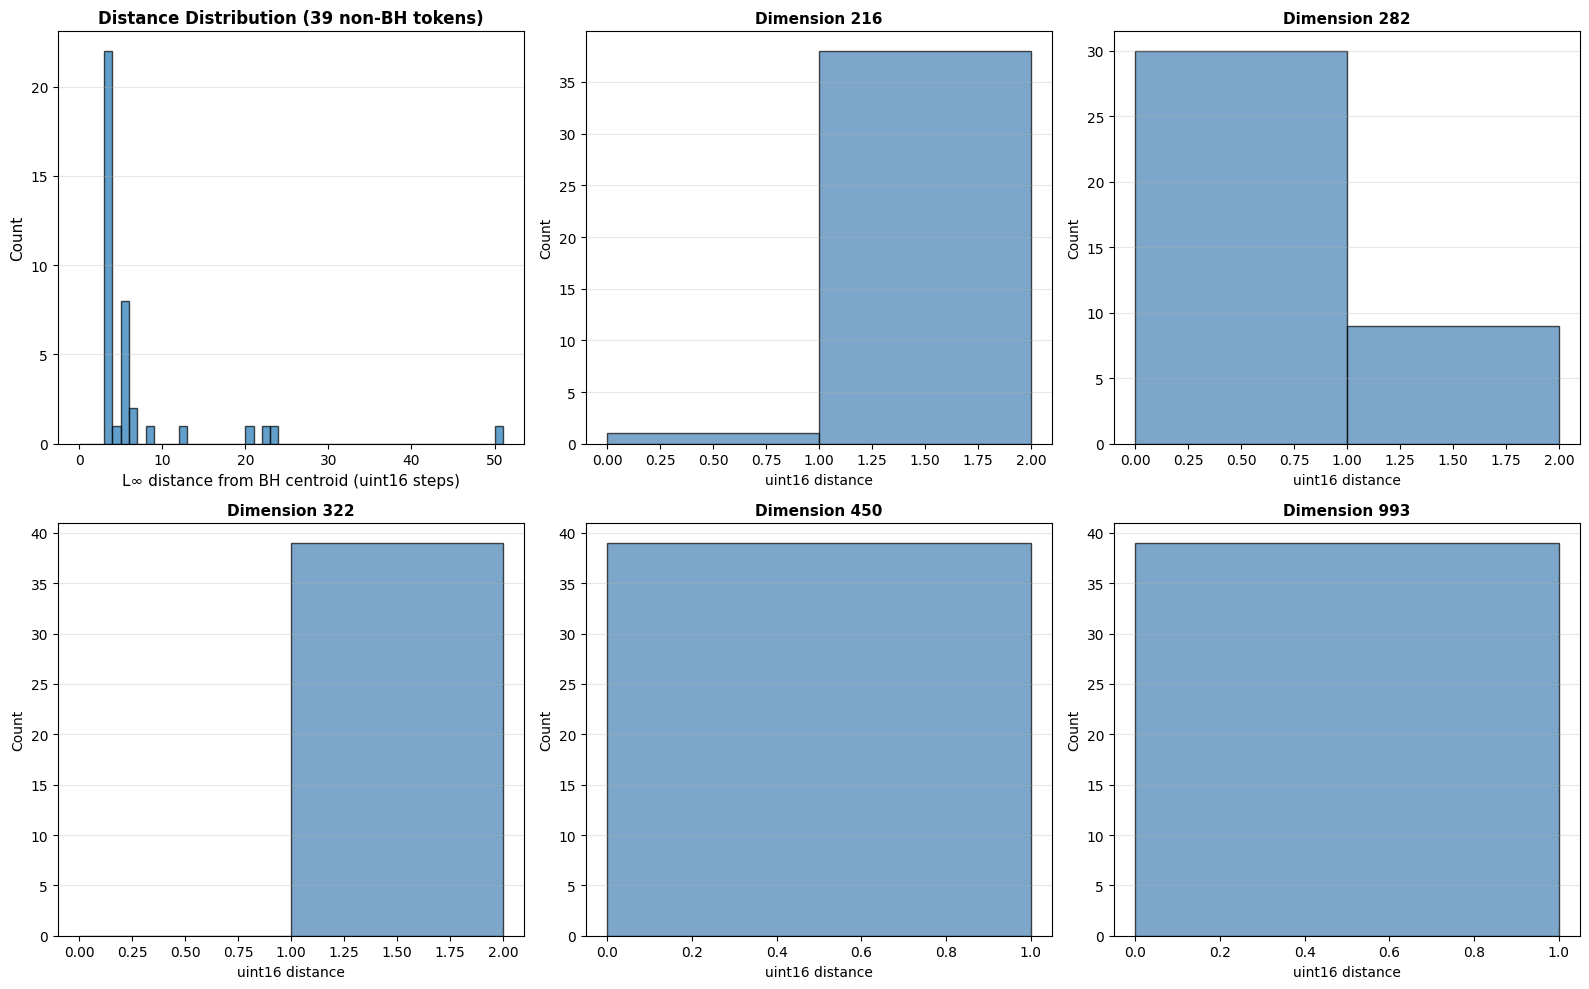

✓ Visualizations complete


In [14]:
if len(non_bh_in_neighborhood) > 0:
    print("\nCreating visualizations...\n")
    
    fig = plt.figure(figsize=(16, 10), dpi=100)
    
    # 1. Histogram: L∞ distances
    ax1 = plt.subplot(2, 3, 1)
    ax1.hist(linf_distances, bins=range(0, int(linf_distances.max())+2), 
             edgecolor='black', alpha=0.7)
    ax1.set_xlabel('L∞ distance from BH centroid (uint16 steps)', fontsize=11)
    ax1.set_ylabel('Count', fontsize=11)
    ax1.set_title(f'Distance Distribution ({len(non_bh_in_neighborhood)} non-BH tokens)', 
                  fontsize=12, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Per-dimension distance distributions (first 5 active dims to fit in 2x3 grid)
    for idx, dim in enumerate(ACTIVE_DIMS[:5]):
        ax = plt.subplot(2, 3, idx + 2)  # Subplots 2-6
        dists = distances_per_dim[dim]
        ax.hist(dists, bins=range(0, int(dists.max())+2), 
                edgecolor='black', alpha=0.7, color='steelblue')
        ax.set_xlabel('uint16 distance', fontsize=10)
        ax.set_ylabel('Count', fontsize=10)
        ax.set_title(f'Dimension {dim}', fontsize=11, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualizations complete")
else:
    print("\n(Skipping visualizations: no non-BH tokens in neighborhood)")

## Summary

In [15]:
print("\n" + "=" * 100)
print("SUMMARY: EXPONENT-MATCHED NEIGHBORHOOD")
print("=" * 100)
print()

print(f"Neighborhood size: {len(neighborhood_token_ids):,} tokens")
print(f"  Black holes: {len(bh_in_neighborhood):,} tokens in {n_black_holes} clusters")
print(f"  Non-black holes: {len(non_bh_in_neighborhood):,} tokens")
print()

if len(non_bh_in_neighborhood) > 0:
    print(f"Non-BH breakdown:")
    print(f"  Unique vectors: {len(vector_groups):,}")
    print(f"  Singletons: {len(singletons):,}")
    print(f"  Small clusters: {len(small_clusters):,}")
    print()
    
    print(f"Spatial distribution (active dimensions):")
    print(f"  L∞ distance range: {linf_distances.min()}-{linf_distances.max()} uint16 steps")
    print(f"  Median L∞ distance: {np.median(linf_distances):.1f} steps")
    print()

print("Key findings:")
print()

if len(non_bh_in_neighborhood) >= 50:
    print("  ✓ DIFFUSION CLOUD CONFIRMED")
    print(f"    {len(non_bh_in_neighborhood)} non-BH tokens occupy the same exponent hypercube as the black holes.")
    print("    This supports the thermal diffusion hypothesis:")
    print("      1. All tokens initialized near the same point")
    print("      2. Early training thermal phase caused Brownian motion")
    print("      3. Some tokens random-walked outward, others stayed in core")
    print("      4. Gradients decayed, everything froze in place")
    print("      5. Result: dense BH core + diffuse singleton cloud")
elif len(non_bh_in_neighborhood) > 0:
    print("  ~ WEAK DIFFUSION CLOUD")
    print(f"    Only {len(non_bh_in_neighborhood)} non-BH tokens found (less than expected).")
    print("    Possible explanations:")
    print("      • Short thermal phase (quick freeze)")
    print("      • Most singletons escaped to different exponents")
    print("      • Strong gravitational collapse into black holes")
else:
    print("  ✗ NO DIFFUSION CLOUD")
    print("    The exponent hypercube contains ONLY the 13 black holes.")
    print("    This suggests:")
    print("      • Either no thermal diffusion occurred, OR")
    print("      • All non-BH tokens escaped to different exponents entirely")

print()
print("=" * 100)


SUMMARY: EXPONENT-MATCHED NEIGHBORHOOD

Neighborhood size: 2,139 tokens
  Black holes: 2,100 tokens in 13 clusters
  Non-black holes: 39 tokens

Non-BH breakdown:
  Unique vectors: 39
  Singletons: 39
  Small clusters: 0

Spatial distribution (active dimensions):
  L∞ distance range: 3-50 uint16 steps
  Median L∞ distance: 3.0 steps

Key findings:

  ~ WEAK DIFFUSION CLOUD
    Only 39 non-BH tokens found (less than expected).
    Possible explanations:
      • Short thermal phase (quick freeze)
      • Most singletons escaped to different exponents
      • Strong gravitational collapse into black holes

